In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision.transforms import InterpolationMode

import time
import random
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import cv2

In [2]:
PATH = "/Users/denniscimorosi/Desktop/Tesi/Logos/"
states_path = PATH + "states.csv"
union_path = PATH + "union/"

In [3]:
states_df = pd.read_csv(states_path)

In [4]:
batch_size = 32
lr = 0.001
epochs = 10

In [5]:
class LogoStates(Dataset):
    def __init__(self, states_df, transform=None,name=''):
        self.states_df = states_df
        
        name = name
        if name != '':
            self.states_df = self.states_df[self.states_df["captcha"].str.contains(name)]
            
        self.transform = transform
        self.to_pil = transforms.ToPILImage()       
        
    def __len__(self):
        return len(self.states_df)
    
    def __getitem__(self, item):
        row = self.states_df.iloc[item]
        captcha, label = row
        
        captcha_img = Image.open(union_path + captcha)
        captcha_img = np.asarray(captcha_img)
        captcha_img = cv2.resize(captcha_img, (28,28), interpolation=cv2.INTER_LINEAR)
        captcha_img = PIL.Image.fromarray(captcha_img)
        
        # 0 se sono uguali 1 se sono diverse (invertito)
        label = 1 if label else 0
        
        if self.transform:
            captcha_img = self.transform(captcha_img)

        return captcha_img, label

In [6]:
# Unseen: estraggo tutti i nomi, shuffle e prendo circa il 15%
n_unseen = 3800
unseen_df = states_df.sort_values(['captcha'])[:n_unseen]
states_df = states_df.sort_values(['captcha'])[n_unseen:]

percentage = round(len(states_df)*15/100)



states_df = states_df.sample(frac=1).reset_index(drop=True)

train_df = states_df[percentage:]
test_df = states_df[:percentage]


len(train_df), len(test_df), len(unseen_df)

(170, 30, 3800)

In [7]:
transform=transforms.Compose([
                    transforms.Grayscale(),
                    transforms.ToTensor()
                 ])
train_ds = LogoStates(train_df, transform,name='')
test_ds = LogoStates(test_df, transform)
unseen_ds = LogoStates(unseen_df, transform)

In [8]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, 
                    multiprocessing_context="fork", num_workers=8)

test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True,
                    multiprocessing_context="fork", num_workers=8)

unseen_loader = DataLoader(unseen_ds, batch_size=3600, shuffle=True,
                    multiprocessing_context="fork", num_workers=8)

In [9]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        print(x.shape)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [11]:
net = CNN()
criterion = nn.CrossEntropyLoss()   
optimizer = optim.Adam(net.parameters(), lr = lr )

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([32, 16, 14, 14])
Epoch number 0
 Current loss 0.6856688261032104

torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([10, 16, 14, 14])


Training:   0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([32, 16, 14, 14])
Epoch number 1
 Current loss 0.6443893313407898

torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([10, 16, 14, 14])


Training:   0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([32, 16, 14, 14])
Epoch number 2
 Current loss 0.6196069121360779

torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([10, 16, 14, 14])


Training:   0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([32, 16, 14, 14])
Epoch number 3
 Current loss 0.5533661246299744

torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([10, 16, 14, 14])


Training:   0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([32, 16, 14, 14])
Epoch number 4
 Current loss 0.5192309021949768

torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([10, 16, 14, 14])


Training:   0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([32, 16, 14, 14])
Epoch number 5
 Current loss 0.5728322863578796

torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([10, 16, 14, 14])


Training:   0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([32, 16, 14, 14])
Epoch number 6
 Current loss 0.46348005533218384

torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([10, 16, 14, 14])


Training:   0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([32, 16, 14, 14])
Epoch number 7
 Current loss 0.39241698384284973

torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([10, 16, 14, 14])


Training:   0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([32, 16, 14, 14])
Epoch number 8
 Current loss 0.29793408513069153

torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([10, 16, 14, 14])


Training:   0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([32, 16, 14, 14])
Epoch number 9
 Current loss 0.2525580823421478

torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([32, 16, 14, 14])
torch.Size([10, 16, 14, 14])


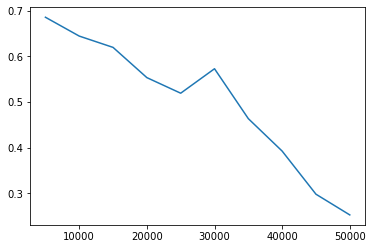

In [12]:
counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in tqdm(range(epochs), desc="Epochs"):

    # Iterate over batches
    for i, (img, label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):

        # Zero the gradients
        optimizer.zero_grad()
        
        # Pass in the two images into the network and obtain two outputs
        output = net(img)

        # Pass the outputs of the networks and label into the loss function
        loss = criterion(output,label)

        # Calculate the backpropagation
        loss.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 5000 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss.item()}\n")
            iteration_number += 5000

            counter.append(iteration_number)
            loss_history.append(loss.item())

show_plot(counter, loss_history)

In [13]:
# Test the model
net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in unseen_loader:
        test_output = net(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        #print(test_output, pred_y)
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
print('Test Accuracy of the model on the test images: %.2f' % accuracy)

torch.Size([3600, 16, 14, 14])
torch.Size([200, 16, 14, 14])
Test Accuracy of the model on the test images: 0.78


In [14]:
# Test the model
net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        test_output = net(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        #print(test_output, pred_y)
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
print('Test Accuracy of the model on the test images: %.2f' % accuracy)

torch.Size([30, 16, 14, 14])
Test Accuracy of the model on the test images: 0.80


In [15]:
# Save the model
torch.save(net.state_dict(), 'model.pt')